# Transfer Learning with TensorFlow Part 1: Feature Extraction

Benefits:
1. Uses an existing neural network architecture that works on problems similar to the intended model
2. Utulizes a working neural network architecture that already learned patters on similar data.

Links:
- [10_food_classes_10_percent](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip)

In [1]:
# How many images are in each folder?
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}")

There are 2 folders and 0 images in 10_food_classes_10_percent
There are 10 folders and 0 images in 10_food_classes_10_percent\test
There are 0 folders and 250 images in 10_food_classes_10_percent\test\chicken_curry
There are 0 folders and 250 images in 10_food_classes_10_percent\test\chicken_wings
There are 0 folders and 250 images in 10_food_classes_10_percent\test\fried_rice
There are 0 folders and 250 images in 10_food_classes_10_percent\test\grilled_salmon
There are 0 folders and 250 images in 10_food_classes_10_percent\test\hamburger
There are 0 folders and 250 images in 10_food_classes_10_percent\test\ice_cream
There are 0 folders and 250 images in 10_food_classes_10_percent\test\pizza
There are 0 folders and 250 images in 10_food_classes_10_percent\test\ramen
There are 0 folders and 250 images in 10_food_classes_10_percent\test\steak
There are 0 folders and 250 images in 10_food_classes_10_percent\test\sushi
There are 10 folders and 0 images in 10_food_classes_10_percent\train


## Creating data loaders (preparing the data)

In [3]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Add the directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test"

# Create the image generator instance and rescale
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                      target_size=IMAGE_SHAPE,
                                      batch_size=BATCH_SIZE,
                                      class_mode="categorical")

print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while the model trains)
Callbacks are extra functionality to add on models to be performed during or after training. Most popular ones are:
- Tracking experiments with the TensorBoard callback
- Model checkpoint with ModelCheckpoint callback
- Stopping a model from training (before training too long and overfitting) with EarlyStopping callback

In [4]:
# Create TensorBoard callback (functionized because it needs to create a 
# new one for each model)
import datetime

def create_tensorboard_callback(dir_name, exp_name):
    log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback


## Create a model using TensorFlow Hub
Model was found from tf.hub.dev
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

Note: Finding a good model can usually be done by looking at https://paperswithcode.com
Finally, many images use https://image-net.org to train models since it is such a big repository

In [5]:
# Compare the two model links from tf.hub
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url ="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependences
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Create a model function to create a model from a URL
def create_model(model_url, num_classes=10):
    """ 
    Takes a TensorFlow Hub URL and creates a Keras Sequential model
    with it.

    Args: 
        model_url (str): A TensorFlow Hub feature extraction URL.
        num_class (int): Number of output neurons in the output layer,
            should be equal to number of target classes, default 10.
    
    Returns:
        An uncompiled Keras Sequential model with model_url as feature
        extractor layer and Dense output layer with num_classes output neurons.
    """
    # Download the pretrained model and 
    feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False, # freeze pre-learnt patterns
                                            name="feature_extraction_layer",
                                            input_shape=IMAGE_SHAPE+(3,)) 
    
    # Create the model
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation="softmax", name="output_layer")
    ])

    return model

### Creating and testing ResNet TensorFlow Hub

In [13]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [14]:
# Compile the resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [24]:
# Fit the model 
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                       exp_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220503-203053
Epoch 1/5
24/24 [==============================] - 17s 604ms/step - loss: 0.3295 - accuracy: 0.9320 - val_loss: 0.6549 - val_accuracy: 0.7772
Epoch 2/5
24/24 [==============================] - 14s 596ms/step - loss: 0.2733 - accuracy: 0.9453 - val_loss: 0.6345 - val_accuracy: 0.7852
Epoch 3/5
24/24 [==============================] - 14s 598ms/step - loss: 0.2375 - accuracy: 0.9627 - val_loss: 0.6321 - val_accuracy: 0.7840
Epoch 4/5
24/24 [==============================] - 14s 601ms/step - loss: 0.2033 - accuracy: 0.9733 - val_loss: 0.6170 - val_accuracy: 0.7884
Epoch 5/5
24/24 [==============================] - 14s 601ms/step - loss: 0.1711 - accuracy: 0.9880 - val_loss: 0.6179 - val_accuracy: 0.7900


Looking back at the previous section, the transfer learnt model performs over double the accuracy over unseen data. The previous model only got an accuracy of 34%. 
The time is also significantly lower (10% of the training dataset was used)

In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
import matplotlib.pyplot as plt
# Plot the validation and training curves
def plot_loss(history):
    """ 
    Returns seperate loss curves for training and validation

    Args:
        history: TensorFlow History object. 
    
    Returns:
        Plots of training/validation loss and accuracy metrics
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()


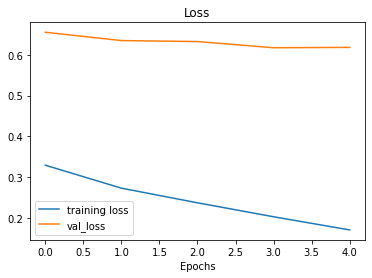

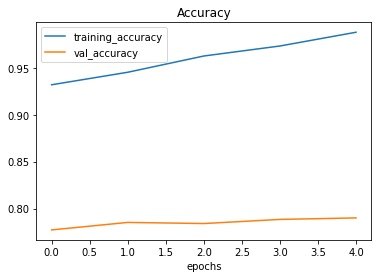

In [25]:
plot_loss(history=resnet_history)

The model seems stagnate near the end (may be overfitting). 
NOTE: the history was ran twice. The losses show the 2nd time it was ran. The overall validation accuracy increased slightly and losses are not improving as much due to it.

### Creating and testing EfficientNet80 TensorFlow Hub Feature Extraction model

In [26]:
# Create the model 
efficient_net = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

In [30]:
# Compile the model
efficient_net.compile(loss="categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# Fit the efficient net model
efficient_net_history = efficient_net.fit(train_data_10_percent,
                                          epochs=5,
                                          validation_data=test_data,
                                          validation_steps=len(test_data),
                                          callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                        exp_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20220503-213754
Epoch 1/5
24/24 [==============================] - 33s 489ms/step - loss: 1.8405 - accuracy: 0.4507 - val_loss: 1.3204 - val_accuracy: 0.7184
Epoch 2/5
24/24 [==============================] - 9s 374ms/step - loss: 1.0618 - accuracy: 0.7760 - val_loss: 0.8770 - val_accuracy: 0.8164
Epoch 3/5
24/24 [==============================] - 9s 366ms/step - loss: 0.7599 - accuracy: 0.8120 - val_loss: 0.7010 - val_accuracy: 0.8416
Epoch 4/5
24/24 [==============================] - 9s 367ms/step - loss: 0.6102 - accuracy: 0.8613 - val_loss: 0.6148 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 9s 370ms/step - loss: 0.5178 - accuracy: 0.8920 - val_loss: 0.5619 - val_accuracy: 0.8604


Compared to the resnet model, the accuracy of the validation increased over around 7% higher. 

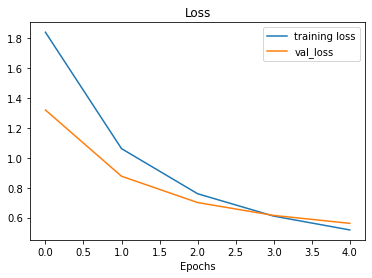

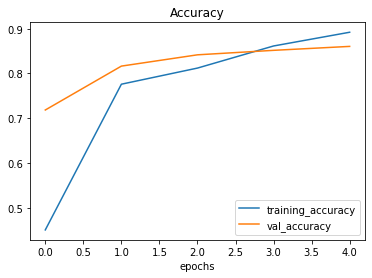

In [31]:
# Plot the history of the efficientnet model
plot_loss(efficient_net_history)

In [38]:
efficient_net.summary(), len(efficient_net.layers[0].weights)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


(None, 309)

## Different types of Transfer learning
- **As is** transfer learning - using an existing model with no changes what so ever.
- **Feature Extraction** transfer learning - Use the prelearnt patterns of an existing model and adjust the output layer for your own problems (e.g. 1000 classes -> 10 classes of food)
- **Fine-tuning** transfer learning - use the prelearnt patterns of an existing model and adjust many of the underlying layers (including new output layers)

### Comparing model results using TensorBoard
When uploading things on TensorBoard.dev, experiments are public.

In [ ]:
# Upload TensorBoard dev record
# Use ! instead
# %reload_ext tensorboard
%tensorboard dev upload --logdir "./tensorflow_hub/" \
--name "EfficientNetB0 vs. ResNet50v2" \
--description "Comparing two TFHub models using a tenth of the training data" \
--one_shot

https://tensorboard.dev/experiment/ojijob6XSBiwuMUoh2rwxg/#scalars&_smoothingWeight=0.656

If it doesn't work then: 

tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50v2" --description "Comparing two TFHub models using a tenth of the training data" --one_shot

Paste in the terminal (be sure you are in the correct directory or cd to it)

In [49]:
# Check out what TensorBoard Experiments uploaded
!tensorboard dev list

https://tensorboard.dev/experiment/ojijob6XSBiwuMUoh2rwxg/
	Name                 EfficientNetB0 vs. ResNet50v2
	Description          Comparing two TFHub models using a tenth of the training data
	Id                   ojijob6XSBiwuMUoh2rwxg
	Created              2022-05-03 22:51:36 (5 minutes ago)
	Updated              2022-05-03 22:51:59 (5 minutes ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7514962
https://tensorboard.dev/experiment/RdTXiKsgQD2ndyQSr1jHOQ/
	Name                 [No Name]
	Description          [No Description]
	Id                   RdTXiKsgQD2ndyQSr1jHOQ
	Created              2022-05-03 22:47:13 (10 minutes ago)
	Updated              2022-05-03 22:47:13 (10 minutes ago)
	Runs                 0
	Tags                 0
	Scalars              0
	Tensor bytes         0
	Binary object bytes  0


Total: 2 experiment(s)


In [51]:
# To delete an accidentally uploaded model
!tensorboard dev delete --experiment_id RdTXiKsgQD2ndyQSr1jHOQ

Deleted experiment RdTXiKsgQD2ndyQSr1jHOQ.
